# Model Training for Ultrasound Image Reconstruction
This notebook sets up the baseline training pipeline for U-Net using ultrasound data.  

In [1]:
import os       # file access
import matplotlib.pyplot as plt     # plotting of the results (possibly later)

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm   # for epoch iteration
from glob import glob   # for dataset preprocessing
from sklearn.model_selection import train_test_split # to perform validation on simulation data
import scipy.io as sio
import numpy as np

############################################################################################################################
# user defined models
from models.resnet import CustomResNet      # custom resnet architecture - CNN baseline
from models.unet   import MicroUNet        # custom unet architecture - better CNN baseline
from models.effunet import EfficientUNetBeamformer  # efficientnet encoder + unet decoder - final model

# user defined scripts
from dataloader.load_rf import load_rf_stack
from dataloader.load_gt import load_gt_stack
from dataloader.dataset import UltrasoundDataset                # custom class to handle ultrasound RF and image data

from utils.visualize_raw import visualize_gt_db
from utils.visualize_raw import visualize_rf_line

from utils.losses import ssim_loss, mae_loss, combined_loss     # loss functions possibly interesting for US data
from utils.metrics import compute_metrics                       # function to compute SSIM and PSNR for comparisons later


ImportError: cannot import name 'CustomUNet' from 'models.unet' (c:\Users\jdszk\OneDrive - ETH Zurich\Desktop\SoCDAML_Project\ReconstructUS\code\models\unet.py)

## Configuration
Define all the training parameters in one variable.

In [ ]:
TARGET_DEPTH = 1600 # target number of samples for all considered RF files
DATASET_SIZE = 300  # number of total samples loaded in the notebook

In [ ]:
CONFIG = {
    'model_name': 'unet',           # options: 'resnet', 'unet', 'effunet'
    'loss_function': 'ssim',          # options: 'ssim', 'mae', 'combined'
    'batch_size': 4,
    'lr': 1e-4,
    'epochs': 100,
    'input_size': None,               # we set it based on the max depth of processed .mat files
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',

    'data_dir_rf': os.path.join('..', 'data', 'raw'),
    'data_dir_img': os.path.join('..', 'data', 'processed'),
    'checkpoints_dir': None, # will be set below
}

# Set checkpoint path
CONFIG['checkpoints_dir'] = os.path.join('..', 'checkpoints', CONFIG['model_name'])

# (Optional) Create the directory if it doesn't exist
os.makedirs(CONFIG['checkpoints_dir'], exist_ok=True)


In [ ]:
import torch

if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)
    print(f"✅ CUDA is available! Using GPU: {device_name}")
else:
    print("❌ CUDA is not available. Training will be **very slow** on CPU.")


❌ CUDA is not available. Training will be **very slow** on CPU.


## Data Loading
We assume .mat for input RF data and .mat for the reconstructed image files.

In [ ]:
# test rf loading
rf_paths  = sorted(glob(os.path.join(CONFIG['data_dir_rf'], 'rf_*.mat')))
rf_tensor = load_rf_stack(rf_paths, target_depth=TARGET_DEPTH)  # Output: [300, TARGET_DEPTH, 128]

print("RF tensor shape:", rf_tensor.shape)   # should be [300, TARGET_DEPTH, 128]

100%|██████████| 6/6 [00:03<00:00,  1.93it/s]

RF tensor shape: torch.Size([450, 3328, 128])


In [ ]:
img_paths = sorted(glob(os.path.join(CONFIG['data_dir_img'], 'img_*.mat')))
gt_tensor = load_gt_stack(img_paths)  # [300, 387, 609]

print("GT tensor shape:", gt_tensor.shape)   # should be [450, 387, 609]

100%|██████████| 6/6 [00:00<00:00, 76.60it/s]

Loaded ..\data\processed\img_00001.mat | raw min: -251.04+20.49j, max: 255.49-144.31j
Loaded ..\data\processed\img_00002.mat | raw min: -230.34+12.23j, max: 224.48-69.72j
Loaded ..\data\processed\img_00003.mat | raw min: -20.52-16.52j, max: 21.48+7.16j
Loaded ..\data\processed\img_00004.mat | raw min: -56.68-21.87j, max: 52.41+5.23j
Loaded ..\data\processed\img_00005.mat | raw min: -63.40-21.24j, max: 65.40-2.54j
Loaded ..\data\processed\img_00006.mat | raw min: -691.39-44.24j, max: 678.56+97.13j
GT tensor shape: torch.Size([450, 387, 609])


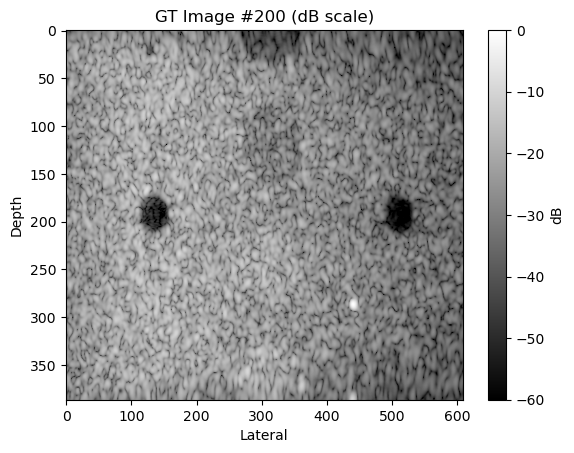

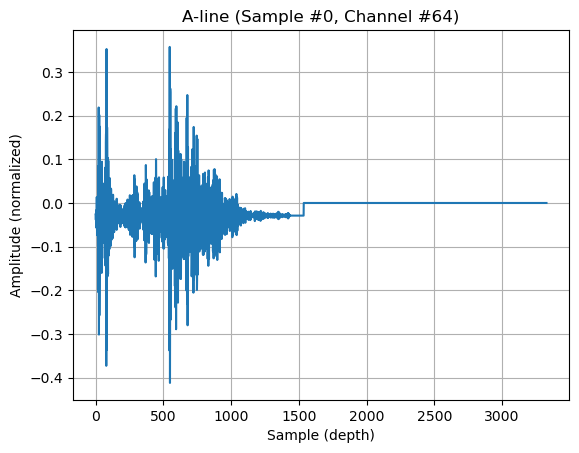

In [7]:
visualize_gt_db(gt_tensor, idx=200)
visualize_rf_line(rf_tensor, file_idx=0, pw_idx=10, ch_idx=64)

## Data Augmentation
In this part we create new tensors with augmented GT images and zeroes out transducer channels. Output of this section should be DataLoader.

In [8]:
# we need train test split first
from sklearn.model_selection import train_test_split

# Indices for splitting
indices = np.arange(rf_tensor.shape[0])
train_idx, temp_idx = train_test_split(indices, test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

# Split tensors
rf_train, gt_train = rf_tensor[train_idx], gt_tensor[train_idx]
rf_val,   gt_val   = rf_tensor[val_idx],   gt_tensor[val_idx]
rf_test,  gt_test  = rf_tensor[test_idx],  gt_tensor[test_idx]

Original shape: torch.Size([360, 387, 609])
Augmented shape: torch.Size([360, 387, 609])


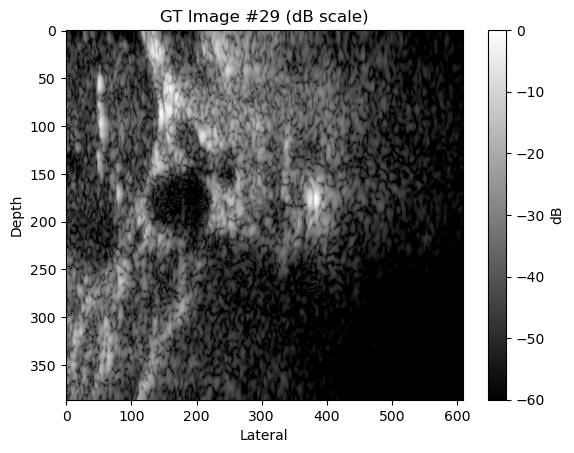

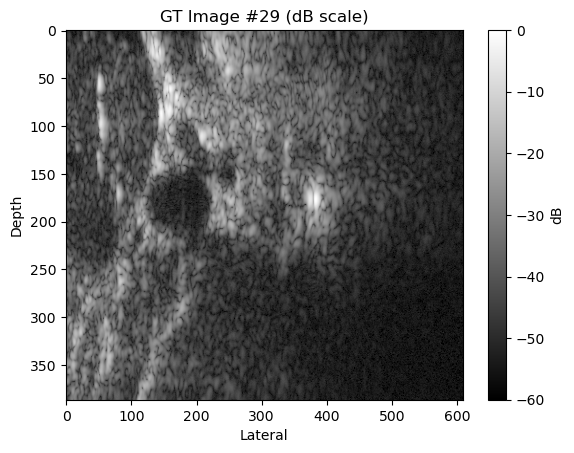

In [19]:
# we need a function to augment GT images
def augment_gt_tensor(gt_tensor, contrast_factor=1.001, noise_std=0.0005, prob=0.95):
    """
    Apply random augmentation (contrast + noise) to each GT image in a tensor.

    Args:
        gt_tensor (torch.Tensor): [N, H, W] GT images.
        contrast_factor (float): How much to jitter contrast.
        noise_std (float): Standard deviation of Gaussian noise.
        prob (float): Probability to apply augmentation per image.

    Returns:
        torch.Tensor: Augmented GT tensor [N, H, W]
    """
    augmented = []

    for i in range(gt_tensor.shape[0]):
        img = gt_tensor[i].clone()

        if torch.rand(1).item() < prob:
            # Contrast jitter
            img = (img - 0.5) * contrast_factor + 0.5

            # Gaussian noise
            noise = torch.randn_like(img) * noise_std
            img = img + noise

            # Normalize again to [0, 1]
            #img = img - img.min()
            #img = img / (img.max() + 1e-8)
            # Normalize each image independently to [0, 1]
            img = (img - img.min()) / (img.max() - img.min() + 1e-8)

            # don't do normalization for now
        augmented.append(img)

    return torch.stack(augmented)


# ==== Test it on gt_train ====
gt_augmented = augment_gt_tensor(gt_train)

print("Original shape:", gt_train.shape)
print("Augmented shape:", gt_augmented.shape)

# Visual check (optional)
from utils.visualize_raw import visualize_gt_db
index_for_testing = 29
visualize_gt_db(gt_train, idx=index_for_testing)
visualize_gt_db(gt_augmented, idx=index_for_testing)


RF original shape:  torch.Size([360, 3328, 128])
RF augmented shape: torch.Size([360, 3328, 128])
Dropped channel indices: [2, 33, 39, 57, 61, 68, 69, 87, 98, 102, 109, 112]


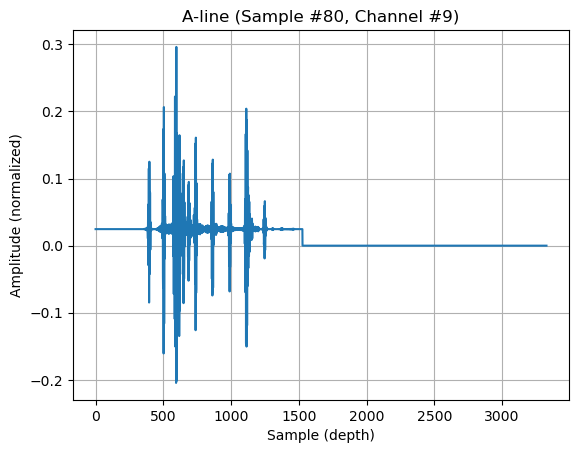

In [10]:
# we need a function to randomly zero out transducer elements [450 x 10% zeroed out x 3000 something]
import torch
import numpy as np
import random

def zero_out_rf_channels(rf_tensor, dropout_rate=0.1):
    """
    Randomly zero out dropout_rate fraction of transducer channels.

    Args:
        rf_tensor (torch.Tensor): [N, D, C] RF data
        dropout_rate (float): Fraction of channels to zero out

    Returns:
        rf_aug (torch.Tensor): Augmented tensor with dropped channels
        dropped_channels (list[int]): Indices of zeroed channels
    """
    N, D, C = rf_tensor.shape
    num_drop = int(C * dropout_rate)
    dropped_channels = sorted(random.sample(range(C), num_drop))

    # Clone to avoid modifying original
    rf_aug = rf_tensor.clone()
    rf_aug[:, :, dropped_channels] = 0

    return rf_aug, dropped_channels

# ==== Test it on rf_train ====
rf_augmented, zeroed_idx = zero_out_rf_channels(rf_train, dropout_rate=0.1)

print("RF original shape: ", rf_train.shape)
print("RF augmented shape:", rf_augmented.shape)
print("Dropped channel indices:", zeroed_idx)

# === Visual sanity check ===
from utils.visualize_raw import visualize_rf_line

file_idx = 80  # plane wave index to visualize
pw_idx   = 8
ch_idx   = 9
# should look flatlined (all zeros)
visualize_rf_line(rf_augmented, file_idx=file_idx, pw_idx=pw_idx, ch_idx=ch_idx)


In [11]:
from torch.utils.data import TensorDataset
# === 1. Augment GT for training ===
gt_train_augmented = augment_gt_tensor(gt_train)

# === 2. Zero out 10% of channels in RF training data ===
rf_train_subsampled, dropped_channels = zero_out_rf_channels(rf_train, dropout_rate=0.1)
print("Dropped channels (for sanity check):", dropped_channels)

# === 3. Create TensorDatasets ===
train_clean_ds = TensorDataset(rf_train.unsqueeze(1), gt_train_augmented)
train_noisy_ds = TensorDataset(rf_train_subsampled.unsqueeze(1), gt_train_augmented)
val_ds         = TensorDataset(rf_val.unsqueeze(1), gt_val)
test_ds        = TensorDataset(rf_test.unsqueeze(1), gt_test)

# (Optional) Print shapes to verify
print("Train Clean:", train_clean_ds[0][0].shape, train_clean_ds[0][1].shape)
print("Train Noisy:", train_noisy_ds[0][0].shape, train_noisy_ds[0][1].shape)
print("Val:", val_ds[0][0].shape, val_ds[0][1].shape)
print("Test:", test_ds[0][0].shape, test_ds[0][1].shape)

Dropped channels (for sanity check): [4, 6, 62, 66, 68, 73, 78, 92, 103, 105, 108, 121]
Train Clean: torch.Size([1, 3328, 128]) torch.Size([387, 609])
Train Noisy: torch.Size([1, 3328, 128]) torch.Size([387, 609])
Val: torch.Size([1, 3328, 128]) torch.Size([387, 609])
Test: torch.Size([1, 3328, 128]) torch.Size([387, 609])


In [12]:
from torch.utils.data import DataLoader, ConcatDataset

train_combined = ConcatDataset([train_clean_ds, train_noisy_ds])

train_loader = DataLoader(train_combined, batch_size=CONFIG['batch_size'], shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=CONFIG['batch_size'], shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=CONFIG['batch_size'], shuffle=False)


In [13]:
# Check a single batch from each loader
train_batch = next(iter(train_loader))
val_batch   = next(iter(val_loader))
test_batch  = next(iter(test_loader))

for name, batch in zip(["Train", "Val", "Test"], [train_batch, val_batch, test_batch]):
    rf, gt = batch
    print(f"{name} RF shape: {rf.shape}, GT shape: {gt.shape}")


Train RF shape: torch.Size([8, 1, 3328, 128]), GT shape: torch.Size([8, 387, 609])
Val RF shape: torch.Size([8, 1, 3328, 128]), GT shape: torch.Size([8, 387, 609])
Test RF shape: torch.Size([8, 1, 3328, 128]), GT shape: torch.Size([8, 387, 609])


## Model Architecture
Here we define the model architecture used for training.

In [14]:
if CONFIG['model_name'] == 'resnet':
    model = CustomResNet()
elif CONFIG['model_name'] == 'unet':
    model = CustomUNet()
elif CONFIG['model_name'] == 'effunet':
    model = EfficientUNetBeamformer()

In [15]:
# we define standard optimizer and scheduler, loss is defined later based on user CONFIG
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG['lr'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [16]:
def train_one_epoch(model, loader, optimizer):
    model.train()
    epoch_loss = 0

    # Select loss function once
    if CONFIG['loss_function'] == 'ssim':
        loss_fn = ssim_loss
    elif CONFIG['loss_function'] == 'mae':
        loss_fn = mae_loss
    elif CONFIG['loss_function'] == 'combined':
        loss_fn = combined_loss
    else:
        raise ValueError(f"Unknown loss function: {CONFIG['loss_function']}")

    for x, y in tqdm(loader):
        x, y = x.to(CONFIG['device']), y.to(CONFIG['device'])
        if y.ndim == 3:
            y = y.unsqueeze(1)  # [B, H, W] → [B, 1, H, W]

        print("shape of y is", y.shape)
        optimizer.zero_grad()
        y_pred = model(x)
        print("shape of y_pred is", y_pred.shape)

        print("target range:", y.min().item(), y.max().item())
        print("pred range:", y_pred.min().item(), y_pred.max().item())

        loss = loss_fn(y_pred, y)
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # we use this if training becomes unstable
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader)


In [17]:
def validate(model, loader):
    model.eval()
    val_loss = 0
    total_psnr, total_ssim = 0.0, 0.0
    total_count = 0  # <- make sure to initialize

    if CONFIG['loss_function'] == 'ssim':
        loss_fn = ssim_loss
    elif CONFIG['loss_function'] == 'mae':
        loss_fn = mae_loss
    elif CONFIG['loss_function'] == 'combined':
        loss_fn = combined_loss
    else:
        raise ValueError(f"Unknown loss function: {CONFIG['loss_function']}")

    with torch.no_grad():
        for x, y in tqdm(loader, desc="Validating"):
            x, y = x.to(CONFIG['device']), y.to(CONFIG['device'])
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            val_loss += loss.item()

            # Detach and move to CPU
            preds = y_pred.detach().cpu().float().numpy()
            targets = y.detach().cpu().float().numpy()

            # Compute metrics per sample
            batch_size = preds.shape[0]
            total_count += batch_size  # <- update count

            for i in range(batch_size):
                pred_i = preds[i, 0]    # remove channel dim: [1, H, W] → [H, W]
                target_i = targets[i, 0]

                psnr, ssim = compute_metrics(target_i, pred_i)
                total_psnr += psnr
                total_ssim += ssim

    return (
        val_loss / len(loader),
        total_psnr / total_count,
        total_ssim / total_count
    )

## Model Training
In this part we set up the training loop, train the model and then save the parameters of the final one.

In [18]:
# this is training already, but it's way too slow
best_val_loss = float('inf')
patience = 10
epochs_no_improve = 0

for epoch in tqdm(range(CONFIG['epochs'])):
    train_loss = train_one_epoch(model, train_loader, optimizer)
    val_loss, val_psnr, val_ssim = validate(model, val_loader)
    scheduler.step()

    print(f"Epoch {epoch+1}/{CONFIG['epochs']} | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"PSNR: {val_psnr:.2f} | SSIM: {val_ssim:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0

        # Save checkpoint
        torch.save(model.state_dict(), os.path.join(CONFIG['checkpoints_dir'], 'best_model.pth'))
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break


  0%|          | 0/150 [00:00<?, ?it/s]

shape of y is torch.Size([8, 1, 387, 609])
shape of y_pred is torch.Size([8, 1, 387, 609])
target range: 0.0 1.0
pred range: 0.2787749171257019 0.8505852222442627


  1%|          | 1/90 [00:34<50:33, 34.08s/it]

shape of y is torch.Size([8, 1, 387, 609])



  0%|          | 0/150 [00:34<?, ?it/s]


KeyboardInterrupt: 

## Model Visualization
We visualize one example of the reconstructed images.

In [ ]:
def visualize_prediction_vs_gt_db(gt_tensor, pred_tensor, idx=0, clim=(-60, 0)):
    """
    Visualizes GT and predicted images side by side in dB scale.

    Args:
        gt_tensor (torch.Tensor): shape [B, 1, H, W]
        pred_tensor (torch.Tensor): shape [B, 1, H, W]
        idx (int): index in the batch to visualize
        clim (tuple): dB range to clip the display, e.g., (-60, 0)
    """
    gt = gt_tensor[idx, 0].detach().cpu().numpy()
    pred = pred_tensor[idx, 0].detach().cpu().numpy()

    gt_db = 20 * np.log10(np.abs(gt) / np.max(gt) + 1e-8)
    pred_db = 20 * np.log10(np.abs(pred) / np.max(pred) + 1e-8)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].imshow(gt_db, cmap='gray', aspect='auto', vmin=clim[0], vmax=clim[1])
    axs[0].set_title("Ground Truth (dB)")
    axs[0].axis('off')

    axs[1].imshow(pred_db, cmap='gray', aspect='auto', vmin=clim[0], vmax=clim[1])
    axs[1].set_title("Reconstruction (dB)")
    axs[1].axis('off')

    plt.suptitle(f"Sample #{idx}")
    plt.colorbar(ax=axs[1], label='dB')
    plt.tight_layout()
    plt.show()


In [ ]:
# Load best model
model.load_state_dict(torch.load(os.path.join(CONFIG['checkpoints_dir'], 'best_model.pth')))
model.eval()

# Get validation batch
x_val, y_val = next(iter(val_loader))
x_val, y_val = x_val.to(CONFIG['device']), y_val.to(CONFIG['device'])

# Predict
with torch.no_grad():
    preds = model(x_val)

# Visualize a few samples
for i in range(3):
    visualize_prediction_vs_gt_db(y_val, preds, idx=i)
